# Decision Tree Regression

In this `Jupyter` notebook, we are going to implement the regression tree from the first principle. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import uuid
import copy

from abc import ABCMeta, abstractmethod

sns.set()
%matplotlib inline

## Introduction

The basic idea of the tree based algorithms is to split the feature space into a set of simple regions. Any given decision tree consists of three types of nodes as depicted in **Figure 1**.

<p><center><img src="images/basic_tree.png" alt="drawing" height="50%" width="50%"></center></p>
<p><center><b>Figure 1</b>: Three types of nodes in a typical tree-based algorithm.</center></p>

At the root node and internal nodes, we ask questions (more details are given below) to partition our data into different segments. Since those partion tules can be represented as a tree, we categorize these types of methods as tree-based algorithms.

## How to Build a Decision Tree?

It is easy to explain the decision tree building process with a 2-D dataset. So consider a dataset with two features: $\{(X_1, X_2)\;|\;X_1, X_2 \in \mathbb{R}\}$ and corresponding response is $y \in \mathbb{R}$. The algorithm works as follows.

1. First, we pick a feature (say $X_1$) from the available features (in this case $X_1$, and $X_2$).
2. Next, we select a threshold (say $t_1$). So all the data where $X_1 <= t_1$ will go to the left sub-tree and the rest will go to the right sub-tree.
3. We continue this process until the stopping criteria are met.

An example tree with decision rules is given in **Figure: 2**:

<p><center><img src="images/tree_building.png" alt="drawing" height="50%" width="50%"></center></p>
<p><center><b>Figure 2</b>: An example tree with decision rules.</center></p>


OK, now we know at high-level how the tree-based algorithms work. However, still, we can't go ahead and code our very own regression tree algorithm. Because there are three black boxes in our tree building algorithm as enumerated below:

1. How to select a feature out of a collection of candidate features?
2. How to select a split point?
3. When are we going to stop the recursive tree building process?

So let's understand how these black boxes work.

### Select a Feature

As we mentioned about the main objective of tree-based algorithm is to partition our dataset into several small regions (say $R_1$, $R_2$, ..., $R_J$) as depicted in **Figure: 2**. Actually for regression trees the goal is to find regions that minimized Mean Squared Error (MSE), given by:

$$\sum_{j=1}^{J}\sum_{i \in R_j}(y_i - \hat{y}_{R_j})^2$$

Also, you will notice that there are infinitely many ways to partition a given dataset into small groups or partitions. Evaluating all these partitions using **`MSE`** is computationally infeasible. Hence, we use a **`top-down`**, **`greedy`** approach  to build our regression (and also classification) tree.

### Slect a Split Point

The next puzzel in our tree building algorithm is selecting a suitable split point. Actually, we need to address this problme for numerical and categorical features separately.

#### Selecting the Optimal Split Point for Categorical Features

This can be easily explained with an example. Consider a dataset which is used for loan default prediction and it has a feature called **Credit History** (denoded by $\mathbf{X \in \{excellent, fair, poor\}}$). So our threshold split selection algorithms works as follows.

1. Partition data into two buckets according to $\mathbf{X = excellent}$, and $\mathbf{X \neq excellent}$ and calculate MSE.

2. Partition data into two buckets according to $\mathbf{X = fair}$, and $\mathbf{X \neq  fair}$ and calculate MSE.

3. Partition data into two buckets according to $\mathbf{X = poor}$, and $\mathbf{X \neq  poor}$ and calculate MSE.

4. Select the categorical value (in this example **excellent**, **fair** or **poor**) which reported the least MSE value.


#### Selecting the Optimal Split Point for Numerical Features

For numerical features following algorithms can be used to select optimal split point.

1. Let $X$ denote a numerical feature and let $v_1$, $v_1$, $...$, $v_{N}$ to denote sorted values of $X$. 

2. For i = 1 ... N-1:
    1. Calculate split point $t_i = \frac{(v_i + v_{i+1})}{2}$
    
    2. Split data based on the rule $X >= t_i$ can calculate MSE.

3. Choose the best $t^*$ with lowest MSE.


### Stopping Criteria

Stopping criteria is used to stop growing very complex trees. Following list shows the most common stopping criteria can be used in tree building algorithms.

1. Depth of the tree
2. Minimum number of data points in leaf nodes.

Great now we have introduced everything we need to know for coding our very own regression tree algorith. So let's go ahead to implement it.

## Training Dataset

We are going use following 1-D regression dataset for training our tree.

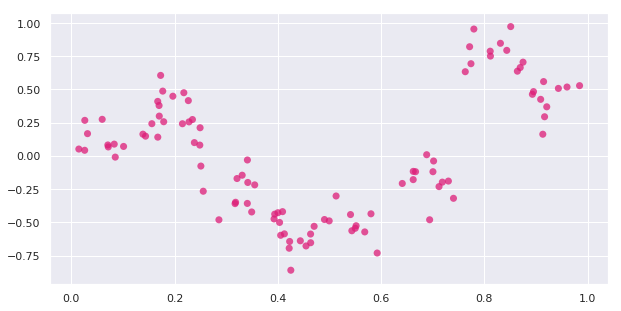

In [2]:
data_train = np.loadtxt('krr-train.txt')

fig = plt.figure(figsize=(10, 5))
axis = plt.axes()
axis.scatter(data_train[:, 0], data_train[:, 1], 
             s=50, color='#dd1c77', alpha=0.75, edgecolors='none')
plt.show()

## Implementation

First we are going to write a couple of utility methods which will be helpful later.

In [3]:
def mean_sq_error(target, predictd):
    return np.mean(np.square(target - predictd))

def predict_note_value(values):
    assert len(values.shape) == 1
    return np.mean(values)

Next, we are going to create three node types we introduced in our discussion.

In [4]:
class Node(object):
    def __init__(self, node_id=None, description=None):
        self.id = node_id
        self.description = description

    def set_id(self, id):
        self.id = id

    def get_id(self):
        return str(self.id)

    def set_description(self, description):
        self.description = description

    def get_description(self):
        return self.description


class Leaf(Node):
    def __init__(self, values, node_id=None, description=None):
        Node.__init__(self, node_id, description)
        self.values = values

    def get_values(self):
        return self.values


class Internal(Node):
    def __init__(self, dim, threshold, left_child, right_child, node_id=None, description=None):
        Node.__init__(self, node_id, description)
        self.dim = dim
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child

In the following cell we are going to write our `BaseTree` class.

In [5]:
class BaseTree(metaclass=ABCMeta):
    def __init__(self, max_depth=None, n_min_leaf=2, n_trials=None):
        self.max_depth = max_depth
        self.n_min_leaf = n_min_leaf
        self.n_trials = n_trials
        self.root_node = None
        #self.num_classes = None

    def fit(self, X, y):
        #self.num_classes = np.unique(y).shape[0]
        self._fit_training_data(X, y,
                                max_depth=self.max_depth,
                                n_min_leaf=self.n_min_leaf,
                                n_trials=self.n_trials)

    def predict(self, X):
        y_predict = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pointer = copy.copy(self.root_node);
            y_predict[i] = self._predict_single_data_point(X[i, :], pointer)
        return y_predict

#     def visualize(self, file_name, file_format='png'):
#         queue = [self.root_node]
#         children = {}
#         graph = gv.Digraph(format=file_format)

#         while queue:
#             vertex = queue.pop(0)
#             graph.node(name=vertex.get_id(), label=vertex.get_description())
#             if type(vertex) is Internal:
#                 queue.append(vertex.right_child)
#                 queue.append(vertex.left_child)
#                 children[vertex.get_id()] = (vertex.right_child.get_id(),
#                                              vertex.left_child.get_id())

#         for key, val in children.items():
#             true_flag = True
#             for child in val:
#                 if true_flag:
#                     graph.edge(key, child, 'True')
#                     true_flag = False
#                 else:
#                     graph.edge(key, child, 'False')
#         graph.render(file_name)

    # private methods
    def _build_node_description(self, values):
#         probabilities = None #predict_node_probability(values, self.num_classes)
#         desc = ''
#         for i in range(probabilities.shape[0]):
#             desc += 'class: {}  prob: {} \n'.format(i, probabilities[i])
#         desc += 'samples: {}\n'.format(values.shape[0])
        return 'desc'

    def _fit_training_data(self, X, y, max_depth=None, n_min_leaf=None, n_trials=None):
        if np.all(y == y[0]):
            return Leaf(y, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        if max_depth is not None and max_depth <= 0:
            return Leaf(y, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        split_parameters = self._split_parameters(X,
                                                  y,
                                                  n_min_leaf=n_min_leaf,
                                                  n_trials=n_trials)
        if split_parameters is None:
            return Leaf(y, self.num_classes, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        split_dim, split_threshold = split_parameters
        mask_left = X[:, split_dim] <= split_threshold
        mask_right = np.logical_not(mask_left)

        left_child = self._fit_training_data(
            X[mask_left],
            y[mask_left],
            max_depth=max_depth - 1 if max_depth is not None else None)

        right_child = self._fit_training_data(
            X[mask_right],
            y[mask_right],
            max_depth=max_depth - 1 if max_depth is not None else None)

        description = 'feature:[{}] <= {}'.format(split_dim, split_threshold)
        self.root_node = Internal(
            dim=split_dim,
            threshold=split_threshold,
            left_child=left_child,
            right_child=right_child,
            node_id=uuid.uuid4(),
            description=description)
        return self.root_node

    def _split_parameters(self, X, Y, n_min_leaf=None, n_trials=None):

        if n_min_leaf is not None and n_min_leaf >= Y.shape[0]:
            return None

        candidate_indices = None
        if n_trials is not None:
            if n_trials > X.shape[1]:
                raise HyperParameterException('n_trials should be less than number of features')
            else:
                candidate_indices = np.random.choice(X.shape[1], size=n_trials, replace=False)

        best_gain = float('inf')
        best_dimension = None
        best_threshold = None
        if candidate_indices is None:
            candidate_indices = range(X.shape[1])

        for dim in candidate_indices:
            feature = X[:, dim]
            threshold, info_grain = self._find_best_split_threshold(feature, Y)
            if info_grain < best_gain:
                best_dimension = dim
                best_gain = info_grain
                best_threshold = threshold

        if best_threshold is None:
            return None
        else:
            return best_dimension, best_threshold

    @abstractmethod
    def _find_best_split_threshold(self, feature_vector, response):
        pass

    @abstractmethod
    def _predict_single_data_point(self, X, node):
        pass

Finally, let's create our `RegressionTree` class.

In [6]:
class RegressionTree(BaseTree):
    def __init__(self, max_depth=None, n_min_leaf=2, n_trials=None):
        super().__init__(max_depth, n_min_leaf, n_trials)

#     def predict(self, X):
#         y_predict = np.zeros(X.shape[0])
#         for i in range(X.shape[0]):
#             pointer = copy.copy(self.root_node);
#             y_predict[i,] = self._predict_single_data_point(X[i, :], pointer)
#         return y_predict

    def _find_best_split_threshold(self, feature_vector, response):
        x = np.copy(feature_vector)
        y = np.copy(response)
        
        assert len(x.shape) == 1
        assert len(y.shape) == 1
        
        sorted_args = np.argsort(x)
        x = x[sorted_args]
        y = y[sorted_args]
        
        best_least_error = float('inf')
        best_split = None
        
        for i in range(x.shape[0] - 1):
            mid = (x[i] + x[i+1]) / 2.0
            less_than_or_eq_indices = np.where(x <= mid)
            greater_than_indices = np.where(x > mid)
            left_error = mean_sq_error(y[less_than_or_eq_indices],
                                         np.mean(y[less_than_or_eq_indices]))
            right_error = mean_sq_error(y[greater_than_indices],
                                        np.mean(y[greater_than_indices]))
            tot_error = left_error + right_error

            if tot_error < best_least_error:
                best_least_error = tot_error
                best_split = mid        
        return best_split, best_least_error
            
#         unique_features = np.unique(feature_vector)
#         best_info_gain = float('-inf')
#         best_category = None
#         for feature in range(unique_features.shape[0]):
#             less_than_or_eq_indices = np.where(feature_vector <= unique_features[feature])[0]
#             greater_than_indices = np.where(feature_vector > unique_features[feature])[0]
#             info_gain = information_gain(response,
#                                          response[less_than_or_eq_indices],
#                                          response[greater_than_indices])
#             if info_gain > best_info_gain:
#                 best_info_gain = info_gain
#                 best_category = unique_features[feature]
#         return best_category, best_info_gain
        
    

    def _predict_single_data_point(self, X, node):
        if type(node) is Leaf:
            return predict_note_value(node.get_values())
        else:
            dim = node.dim
            feature = X[dim]
            if feature <= node.threshold:
                return self._predict_single_data_point(X, node.left_child)
            else:
                return self._predict_single_data_point(X, node.right_child)


Finally, let's train our `RegressionTree` model using the dataset shown above.

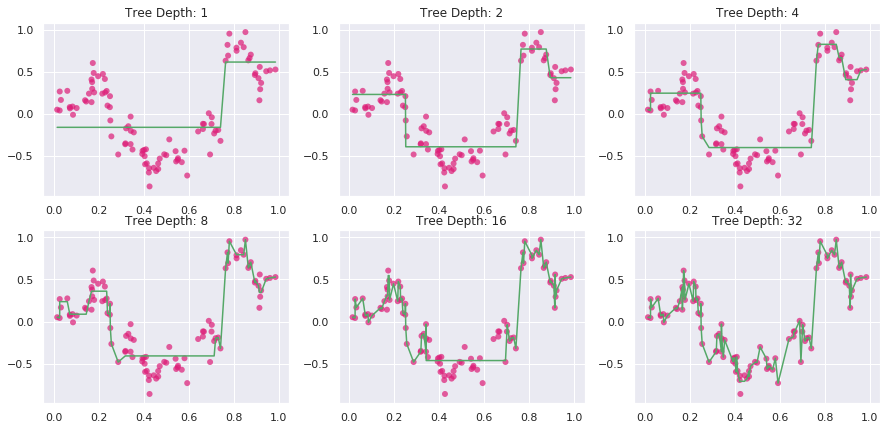

In [7]:
def plot_subplot(axis, X, y, tree_depth,
                color='#dd1c77', alpha=0.5, edgecolors='none'):
    
    def fit_predict(X_train, y_train, tree_depth, n_min_leaf=5):
        model = RegressionTree(max_depth=tree_depth, n_min_leaf=n_min_leaf)
        model.fit(X_train, y_train)
        return model.predict(X_train)

    idx = np.argsort(X)
    
    axis.scatter(X, y, color='#dd1c77', alpha=0.7, edgecolors='none')
    y = fit_predict(X.reshape(X.shape[0], 1), y, tree_depth)
    axis.plot(X[idx], y[idx],  'g-')
    axis.set_title('Tree Depth: {}'.format(tree_depth))


fig, axes = plt.subplots(2, 3, figsize=(15, 7))
tree_depths = iter([1, 2, 4, 8, 16, 32])

for i in range(2):
    for j in range(3):
        plot_subplot(axes[i][j], data_train[:, 0], data_train[:, 1], next(tree_depths))
plt.show()

## Summary

In this Jupyter notebook we studies how to implement a Regression Tree algorithm from the first principle. Trees are really good if interpretability is one of your major concerns. However, trees tend to overfit very easily. Hence, its testing performance might be poor when it compares to other regression algorithms. So it would be a good idea to look at **`RandomForest`** algorithm if generalization is one of our top priorites. 

## References and Further Reading

1. Chapter 8 of the Introduction to Statistical Learning book is a very good and accesible introduction to tree based mehtods. URL: https://www-bcf.usc.edu/~gareth/ISL/

2. Prof: Nando de Freitas's Machine Learning course contains a really interisting introduction to decision trees. URL: https://www.youtube.com/watch?v=-dCtJjlEEgM&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=11

3. A slightly advanced introduction to decision tree can be found in Prof: David S. Rosenberg's Machine Learning course. URL: https://bloomberg.github.io/foml/#home